In [117]:
import os
import numpy as np
import pandas as pd
import networkx as nx
import pickle
from sklearn.model_selection import train_test_split

In [123]:
os.chdir('data')
files = np.array(os.listdir())
## tous les fichiers
filenames = files[[f.lower().endswith('pickle') for f in files]]

In [129]:
print(filenames)
print(len(filenames))
#On a 9 datasets contenant des articles, pour la demonstration de l'analyse on utilisera le 9éme uniquement

['20240124_dataset_1895_assr.pickle' '20240125_dataset_autog_cemot.pickle'
 '20240125_dataset_cep_efr.pickle' '20240125_dataset_emixx_grif.pickle'
 '20240125_dataset_hedu_karst.pickle' '20240125_dataset_ktema_numi.pickle'
 '20240125_dataset_ofce_receo.pickle' '20240125_dataset_recod_rqdi.pickle'
 '20240125_dataset_rscir_xxs.pickle']
9


In [167]:
def load_file(dataframe=[], filenames=[]):
    files_to_load=filenames
    for f in files_to_load:
        with open(f, 'rb') as f:
            file = pickle.load(f)
        if len(dataframe)==0:
            identifiant = [value for value in file if "identifier" in value]
            creators = [value for value in file if "creator" in value]
            cites = [value for value in file if "cites" in value]
            cols = identifiant + creators + cites
            dataframe = file[cols]
        else:
            identifiant = [value for value in file if "identifier" in value]
            creators = [value for value in file if "creator" in value]
            cites = [value for value in file if "cites" in value]
            cols = identifiant + creators + cites
            dataframe = pd.concat([dataframe, file[cols]], join = "outer")
    return dataframe


In [172]:
data=load_file(dataframe=[],filenames=filenames[8:9])#seulement le 9ème set
#data=load_file(dataframe=data, filenames=filenames[0:8])#tous les autres
len(data)

59529

## Extraction du domaine

In [177]:
#extraction de l'indicateur de domaine dans l'index des articles
y = [st[len("http://data.persee.fr/doc/"):st.find("_")] for st in data.index]

#correspondances entre nom de domaines en français et indicateur de domaines
domaines = pd.read_csv("20240141_disciplines.csv", sep = ";")

#listes du nom de domaine pour chaque article
dom=[]
for i in range(len(y)):
    domaine=domaines[domaines.collection_id == y[i]].Discipline
    if len(domaine)==0:
        domaine="non renseigné" #la classe n'est parfois pas spécifiée
    else:
        domaine=domaine.values[0]
    dom.append(domaine)

In [182]:
print(np.unique(dom)) #les classes présentes dans ce set
print(len(np.unique(dom)))#

['Archeologie (M.Anc.)' 'Arts (h. art archi.)' 'Droit' 'Etudes classiques'
 'Etudes g. a. cultur.' 'Etudes regionales' 'Geographie…' 'Histoire'
 'Litterature' 'Pluri. Par essence' 'Religion theologie'
 'Science education' 'Science environmnt' 'Science politique'
 'Sciences Terre' 'Sociologie']
16


In [203]:
def count_classes(class_list=[]):
    class_count=[]
    for domaine in np.unique(class_list):
        class_count.append(class_list.count(domaine))
    return class_count

In [184]:
import matplotlib.pyplot as plt

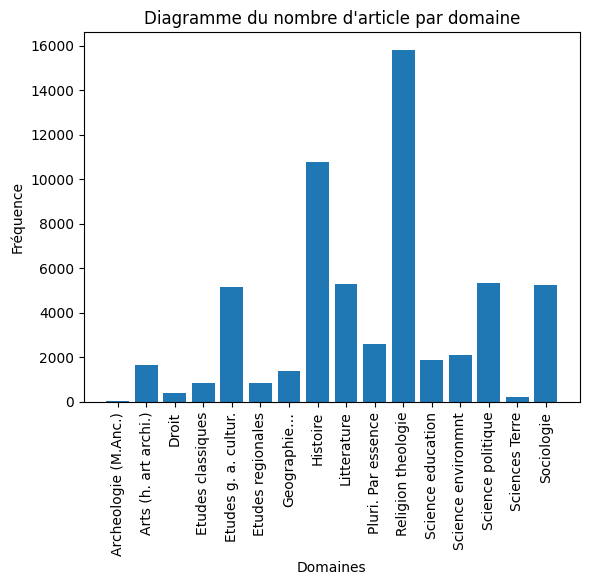

In [204]:
#Diagramme du nombre d'article par domaine
class_count=count_classes(dom)
plt.bar(np.unique(dom), class_count)
plt.xlabel('Domaines')
plt.ylabel('Fréquence')
plt.title("Diagramme du nombre d'article par domaine")
plt.xticks(rotation=90)
plt.show()#large sur représentation des articles de théologie

## Construction du graphe

In [256]:
#on commence par extraire un sous ensemble des données pour permettre la construction d'un graphe facilement manipulable
#pour cela on selectionne 1000 articles et on stratifie par domaine pour conservé la structure 
data_for_graph, Nul, class_for_graph, Nul = train_test_split(data,
                                                          dom,
                                                          train_size = 500,
                                                          test_size=100, 
                                                          stratify = dom,
                                                          random_state=19032024
                                                         )

In [271]:
# enregistrement du DataFrame correspondant à ces données 

#titre préparé
data_for_graph["titre"] = file['dcterms:title{Literal}'].loc[data_for_graph.index].values
data_for_graph["domaine"] = class_for_graph
data_for_graph.to_csv("data.csv")

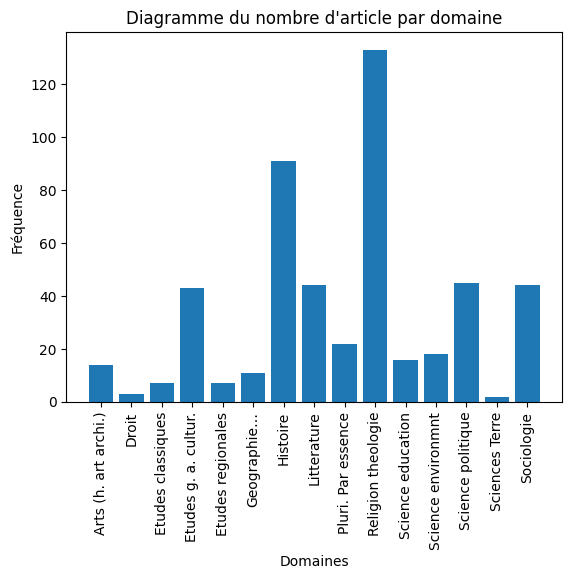

In [257]:
#Diagramme du nombre d'article par domaine
class_count=count_classes(class_for_graph)
plt.bar(np.unique(class_for_graph), class_count)
plt.xlabel('Domaines')
plt.ylabel('Fréquence')
plt.title("Diagramme du nombre d'article par domaine")
plt.xticks(rotation=90)
plt.show()#grace à la stratification on conserve la proportion par domaine

In [258]:
#fonction permettant de construire les liens entre articles à partir des colonnes
#l'idée est de naviguer toutes les colonnes 

#On précise que cette fonction est tirée du travail de nos camarades Ugo Zennaro et Walid Ghalleb
#nous avons choisi de l'utiliser en état après discussion camarade car elle nous a semblé tout à fait efficace
def get_edge(df, col_source, col_target):
    graph = nx.Graph()
    graph.add_nodes_from(df.index)
    col = [value for value in df.columns if col_target in value]
    for c in col:
        for i in range(len(col_source)):
            for j in range(len(df)):
                if (i != j) and (col_source[i]==df[c].iloc[j]):
                    graph.add_edge(df.index[i],df.index[j])
    return graph

In [233]:
from tqdm import tqdm

In [260]:
coauthoring_graph = nx.Graph()

for col in tqdm(data_for_graph.columns):
    if "cites" in col:
        G0 = get_edge(data_for_graph, data_for_graph[col], "cites")
        coauthoring_graph = nx.compose(coauthoring_graph, G0)


100%|██████████| 139/139 [8:24:40<00:00, 217.84s/it]  


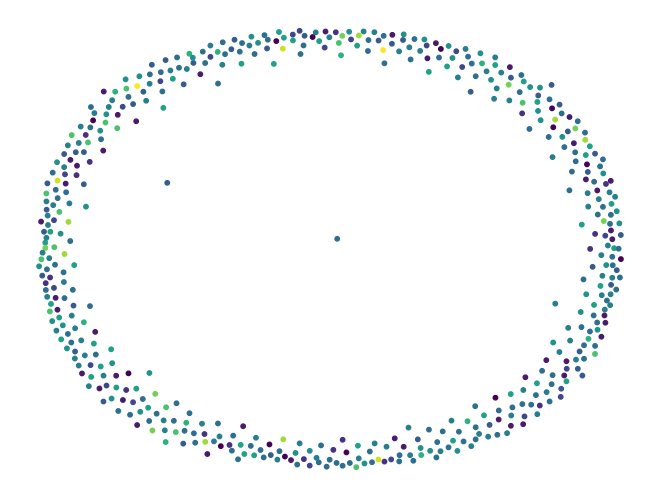

In [261]:
#encodage des classes au format integer pour les utilisation comme coloration des noeuds
domaine_code=[np.where(np.array(list(dict.fromkeys(class_for_graph)))==e)[0][0]for e in class_for_graph]

#dessin du graph avec coloration des noeuds par domaine
nx.draw(coauthoring_graph, node_color=domaine_code, node_size=10, arrowsize = 10)

In [262]:
#très peu de liens.
print("Nombre de liens " + str(len(coauthoring_graph.edges)))

Nombre de liens 0


In [277]:
# export du graphe
nx.write_gexf(coauthoring_graph, "coauteur.gexf")